In [1]:
import numpy as np
from scipy.stats import bernoulli
import matplotlib as plt
from matplotlib import pyplot
from scipy.interpolate import make_interp_spline
import random 
import math
import Sim as sim
from multiprocess import Pool

In [4]:
class BernoulliBandit :
    def __init__ (self , means):
        for i in means:
            assert(i <= 1 and i >= 0)
        self.means = means
        self.k = len(means)
        self.best_mean = max(means)
        self.regret = 0
# Accepts a parameter 0 <= a <= K -1 and returns the
# realisation of random variable X with P(X = 1) being
# the mean of the (a +1) th arm .
    def pull (self , a):
        self.regret += (self.best_mean - self.means[a])
        return bernoulli.rvs(self.means[a], size=1)

In [2]:
class GaussianBandit:
    def __init__ (self , means):
        self.means = means
        self.k = len(means)
        self.best_mean = max(means)
        self.regret = 0
        
    def pull (self , a):
        self.regret += (self.best_mean - self.means[a])
        return random.gauss(self.means[a], 1)


In [3]:
def ucb(delta, bandit, n):
    k = bandit.k #number of arms
    upper_bounds = float('inf') * np.ones(k) #set upper bounds to infinity
    result = [] #to store pairs of a_t, x_t
    means = np.zeros((k,2)) #to store means and T_i
    for i in range(n):
        arm = np.argmax(upper_bounds)
        reward = bandit.pull(arm)
        result.append((arm, reward))
        means[arm,0] = (means[arm,0] * means[arm,1] + reward)/(means[arm,1]+1)
        means[arm,1] += 1
        upper_bounds[arm] = means[arm,0] + np.sqrt(2*np.log(1/delta)/means[arm,1])
    return result, bandit.regret

## Q1
### a)
$\mathbb{P}\Bigl(\hat{\mu}-\mu \geq \sqrt{\frac{2log(1/\delta)}{T}}\Bigr) = \sum_{n=1}^\infty \mathbb{E}\Bigl[\{\mathbb{1}\{T=n\}\mathbb{1}\Bigl\{\sum_{t=1}^n(X_t-\mu)\geq\sqrt{2nlog(1/\delta)}\Bigr\}\Bigr]
\\ =\sum_{n=1}^\infty \mathbb{E}\Bigl[\mathbb{E}\bigl[\mathbb{1}\{T=n\}\mathbb{1}\Bigl\{\sum_{t=1}^n(X_t-\mu)\geq \sqrt{2nlog(1/\delta)}\Bigr\}|T\bigr]\Bigr]
\\ =\sum_{n=1}^\infty \mathbb{E}\Bigl[\mathbb{1}\{T=n\}\mathbb{E}\bigl[\mathbb{1}\Bigl\{\sum_{t=1}^T(X_t-\mu)\geq \sqrt{2Tlog(1/\delta)}\Bigr\}|T\bigr]\Bigr]
\\ \leq \sum_{n=1}^\infty\mathbb{E}[\mathbb{1}\{T=n\}\delta]
\\ = \delta$

### b) (discuss in the meeting)
Not sure how to use law of iterated logarithm;

$T= min\bigl\{n:\sum_{t=1}^n(X_t-\mu)\geq\sqrt{2nlog(1/\delta)}\bigr\}$

$T<\infty$ because $\sum_{t=1}^n(X_t-\mu)$ grows just as fast as $\sqrt{2nloglogn}$ which grows faster than $\sqrt{2nlog(1/\delta)}$  but how to express that mathematically?

### c) 
$\mathbb{P}\Bigl(\hat{\mu}-\mu \geq \sqrt{\frac{2log(T(T+1)/\delta)}{T}}\Bigr) \leq \mathbb{P}\Bigl(\exists n : \sum_{t=1}^n(X_t-\mu)\geq \sqrt{2nlog(n(n+1)/\delta)}\Bigr)
\\ \leq \sum_{n=1}^\infty \frac{\delta}{n(n+1)}
\\ = \delta$


## Q2:
## a)

For $\sigma$-subgaussian we have that $\frac{1}{n}\sum_{i=1}^n(X_i - \mu)$ is $\frac{\sigma}{\sqrt{n}}$- subgaussian. Therefore 7.1 becomes:
$\\ \mathbb{P}\Bigl(\mu\geq \hat{\mu} + \sqrt{\frac{2\sigma^2log(1/\delta)}{n}}\Bigr)\leq \delta,\forall\delta\in (0,1)$

7.2 then becomes:
$$UCB_i(t-1,\delta)=   \left\{
\begin{array}{ll}
      \infty &{ },T_i(t-1)=0 \\
      \hat{\mu}_i(t-1)+\sqrt{\frac{2\sigma^2log(1/\delta)}{T_i(t-1)}} &,{ } otherwise\\
\end{array} 
\right.  $$

## b)
$$UCB_i(t-1,\delta)=   \left\{
\begin{array}{ll}
      \infty &{ },T_i(t-1)=0 \\
      \hat{\mu}_i(t-1)+\sqrt{\frac{2\sigma_i^2log(1/\delta)}{T_i(t-1)}} &,{ } otherwise\\
\end{array} 
\right.  $$

## c) 
Follow the proof of the bound adding the extra $\sigma^2$ term, it will cancel out when $\Delta_i$=0 

## Q3) (Discuss in the meeting)



## Q4) (Discuss lower bounds in the meeting)


In [7]:
def phaseducb_i(bandit, delta, n):
    k = bandit.k #number of arms
    upper_bounds = float('inf') * np.ones(k) #set upper bounds to infinity
    result = [] #to store pairs of a_t, x_t
    means = np.zeros((k,2)) #to store means and T_i
    for i in range(k): #pull each arm once
        reward = bandit.pull(i)
        result.append((i, reward))
        means[i,0] = reward
        means[i,1] = 1
        upper_bounds[i] = means[i,0] + np.sqrt(2*np.log(1/delta))
    for i in range(n-k):
        if(math.log(i+2, 2)-math.floor(math.log((i+2), 2)) == 0): ##only updates the arm at the beginning of each phase
            arm = np.argmax(upper_bounds)
        reward = bandit.pull(arm)
        result.append((arm, reward))
        means[arm,0] = (means[arm,0] * means[arm,1] + reward)/(means[arm,1]+1)
        means[arm,1] += 1
        upper_bounds[arm] = means[arm,0] + np.sqrt(2*np.log(1/delta)/means[arm,1])
    
    return result, bandit.regret

## Q5) (Discuss lower bounds in the meeting)


In [3]:
def phaseducb_ii(bandit, delta, n, alpha):
    k = bandit.k #number of arms
    upper_bounds = float('inf') * np.ones(k) #set upper bounds to infinity
    result = [] #to store pairs of a_t, x_t
    means = np.zeros((k,2)) #to store means and T_i
    
    for i in range(k): #pull each arm once
        reward = bandit.pull(i)
        result.append((i, reward))
        means[i,0] = reward
        means[i,1] = 1
        upper_bounds[i] = means[i,0] + np.sqrt(2*np.log(1/delta))
        
    arm = np.argmax(upper_bounds)
    t_l = np.array(means[:,1]) #T_i(t_l - 1), array of number of times each arm is pulled before the beginning of current phase
    for i in range(n-k):
        if(means[arm,1] >= alpha * t_l[arm]): ##only updates the arm when T_i(t) >= alpha * T_i(t_l-1)
            t_l[arm] = means[arm,1]
            arm = np.argmax(upper_bounds)
        reward = bandit.pull(arm)
        result.append((arm, reward))
        means[arm,0] = (means[arm,0] * means[arm,1] + reward)/(means[arm,1]+1)
        means[arm,1] += 1
        upper_bounds[arm] = means[arm,0] + np.sqrt(2*np.log(1/delta)/means[arm,1])
    
    return result, bandit.regret

## <center>Empirical Comparison between UCB($\delta$), UCB(I) and UCB(II)</center>

## Fixing $\nu = (\mathcal{N}(0,1), \mathcal{N}(-0.1,1), \mathcal{N}(-0.15,1))$

### <center> Phased-UCB(II) </center>

In [ ]:
trials = 100 ##100 x 8 trials
horizon = 1000
n = 8
alphas = np.linspace(1.5, 4, 100)
pool = Pool(processes = n)
multiple_results = []
for i in range(n):
    multiple_results.append(pool.apply_async(sim.sim_ucbii, (trials, horizon,alphas, )))
data = [res.get() for res in multiple_results]

Text(0.5, 1.0, '$\\bar{R}_n$ of UCB(II) applied on $\\nu$ against $\\alpha$')

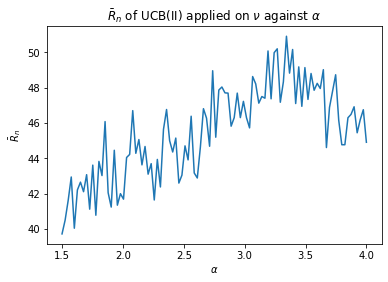

In [3]:
# pyplot.rcParams.update({'font.size': 14})
pyplot.plot(np.linspace(1.5,4,100), mean_regrets)
pyplot.xlabel("$\\alpha$")
pyplot.ylabel("$\\bar{R}_n$")
pyplot.title("$\\bar{R}_n$ of UCB(II) applied on $\\nu$ against $\\alpha$") ##delta = 0.1

## <center> UCB($\delta$) </center>

In [9]:
trials = 100 ##100 x 8 trials
horizon = 1000
n = 8
deltas = np.linspace(1/(1.5 * horizon**2), 1/2 , 500)
pool = Pool(processes = n)
multiple_results = []
for i in range(n):
    multiple_results.append(pool.apply_async(sim.sim_ucb, (trials, horizon,deltas,)))
data = [res.get() for res in multiple_results]
mean_regrets= np.mean(data, axis = 0)

Text(0.5, 1.0, '$\\bar{R}_n$ of UCB($\\delta$) against $\\delta$')

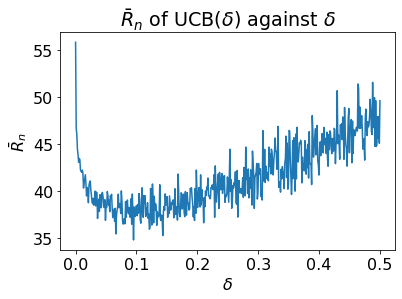

In [10]:
pyplot.plot(deltas, mean_regrets)
pyplot.rcParams.update({'font.size': 16})
pyplot.xlabel("$\\delta$")
pyplot.ylabel("$\\bar{R}_n$")
pyplot.title("$\\bar{R}_n$ of UCB($\\delta$) against $\\delta$")

## <center> Phased-UCB(I) </center>

In [2]:
trials = 200 ##200 x 8 trials
horizon = 1000
n = 8
deltas = np.linspace(1/horizon**2, 0.2, 100)
pool = Pool(processes = n)
multiple_results = []
for i in range(n):
    multiple_results.append(pool.apply_async(sim.sim_ucbi, (trials, horizon,deltas,)))
data = [res.get() for res in multiple_results]
mean_regrets= np.mean(data, axis = 0)

Text(0.5, 1.0, '$\\bar{R}_n$ of UCB(I) against $\\delta$')

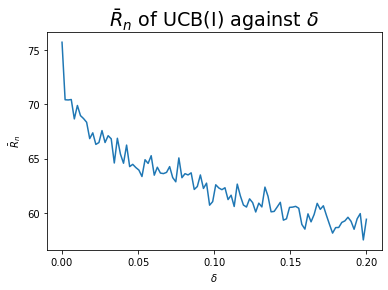

In [3]:
pyplot.plot(deltas, mean_regrets)
pyplot.rcParams.update({'font.size': 16})
pyplot.xlabel("$\\delta$")
pyplot.ylabel("$\\bar{R}_n$")
pyplot.title("$\\bar{R}_n$ of UCB(I) against $\\delta$")

## Q8


In [4]:
trials = 200 
horizon = 1000
n = 8
Deltas = np.linspace(0.01, 1, 100)
pool = Pool(processes = n)
multiple_results = []
for i in range(n):
    multiple_results.append(pool.apply_async(sim.sim_ucb_Delta, (trials, horizon, Deltas,0.1,)))
data = [res.get() for res in multiple_results]
mean_regrets= np.mean(data, axis = 0)

Text(0.5, 1.0, '$UCB(\\delta)$')

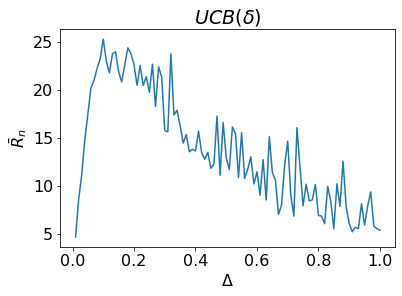

In [8]:
pyplot.plot(Deltas, mean_regrets) ##400 trials
pyplot.rcParams.update({'font.size': 16})
pyplot.xlabel("$\\Delta$")
pyplot.ylabel("$\\bar{R}_n$")
pyplot.title("$UCB(\\delta)$")

Text(0.5, 1.0, '$UCB(\\delta)$')

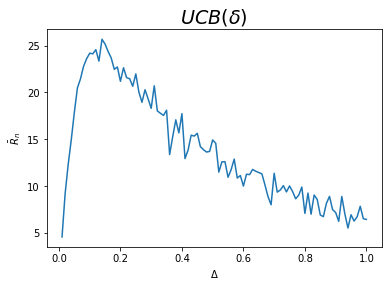

In [5]:
pyplot.plot(Deltas, mean_regrets) ##1600 trials
pyplot.rcParams.update({'font.size': 16})
pyplot.xlabel("$\\Delta$")
pyplot.ylabel("$\\bar{R}_n$")
pyplot.title("$UCB(\\delta)$")

In [ ]:
## one nearest neighbor ucb for noiseless reward